<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/AlienVsPredator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alien versus Predator Challenge**

Importamos las librerías que vamos a utilizar

In [1]:
# Cargamos las librerías necesarias
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader



# Usando GPU

In [2]:
print(torch.cuda.is_available())
device = 'cuda'

True


# Carga y preprocesado de imágenes

In [3]:
# Definimos transformaciones
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

## Creamos los dataloaders
batch_size = 32

# Datasets
train_path = './data/train'
validation_path = './data/validation'

train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
validation_dataset = torchvision.datasets.ImageFolder(root=validation_path, transform = transform )

# Dataloader
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=2)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes
classes = ('alien', 'predator')

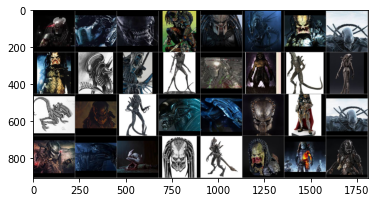

<Figure size 864x576 with 0 Axes>

predator predator alien predator predator alien predator alien predator alien alien alien predator predator alien alien alien predator alien alien alien predator predator alien predator alien alien predator alien predator predator predator


In [4]:
# Mostramos algunas imágenes

# Función para mostrar imagenes
def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.figure(figsize=(12,8))
  plt.show()

# Seleccionamos alguans imágenes aleatorias
dataiter = iter(trainloader)

images, labels = dataiter.next()

# Mostramos imágenes
imshow(make_grid(images))
print(' '.join(classes[labels[j]-1] for j in range(labels.size(0))))

# Cargamos modelo VGG19

In [5]:
#VGG19
vgg_base = torchvision.models.vgg19(pretrained=True)
print(vgg_base)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
# Congelamos los pesos de la red
for params in vgg_base.parameters():
  params.require_grad = False

# Modificamos la úlitma capa
number_features = vgg_base.classifier[6].in_features
layers=list(vgg_base.classifier.children())[:-1]
layers.extend([torch.nn.Linear(number_features, len(classes))])
vgg_base.classifier = torch.nn.Sequential(*layers)
print(vgg_base)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
vgg_base = vgg_base.to(device)

In [8]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_base.parameters(), lr=0.001, momentum=0.9)

# Entrenamiento

In [12]:
epochs = 25
train_loss = []
vgg_base.train()

for epoch in range(epochs):
  running_loss = 0.0

  for data in trainloader:
    images, labels= data
    labels = labels -1 
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = vgg_base(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)

  loss = running_loss/len(trainloader)
  train_loss.append(loss)

  print('epoch [%d/%d] loss: %.3f' % (epoch+1, epochs, loss))

print('Entrenamiento completado')
  
                                        


epoch [1/25] loss: 0.013
epoch [2/25] loss: 0.014
epoch [3/25] loss: 0.015
epoch [4/25] loss: 0.009
epoch [5/25] loss: 0.011
epoch [6/25] loss: 0.012
epoch [7/25] loss: 0.007
epoch [8/25] loss: 0.011
epoch [9/25] loss: 0.008
epoch [10/25] loss: 0.006
epoch [11/25] loss: 0.005
epoch [12/25] loss: 0.007
epoch [13/25] loss: 0.006
epoch [14/25] loss: 0.005
epoch [15/25] loss: 0.006
epoch [16/25] loss: 0.004
epoch [17/25] loss: 0.005
epoch [18/25] loss: 0.004
epoch [19/25] loss: 0.003
epoch [20/25] loss: 0.005
epoch [21/25] loss: 0.003
epoch [22/25] loss: 0.006
epoch [23/25] loss: 0.004
epoch [24/25] loss: 0.003
epoch [25/25] loss: 0.005
Entrenamiento completado


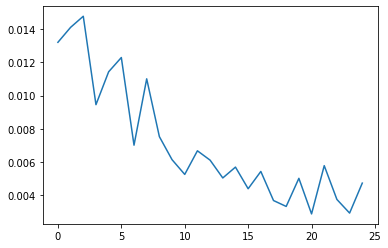

In [13]:
plt.plot(train_loss)

# Visualizamos la predicción de algunas imágenes

In [50]:
images

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -